In this third step we'll actually be optimizing the portfolio. After some research there's a great library for doing this in PyPortfolioOpt, but because we're dealing with weekly returns and not daily price values it's better to do it manually. We'll be documenting the fundamental concepts and applications as instructed to.

In order to keep optimization simple given our deadline, we'll be employing efficient frontier. This method finds the best portfolio weights by maximizing returns and minimizing measuring risk (volatility). This is done by projecting lots of scenerios with different weights in each of our possible assets. 

We then can find the minimum variance porfolio with the highest return. 

We can also find the protfolio with the highest sharpe ratio (the highest return versus risk).  

Third, we can find the portfolio with the highest return regardless of volatility.

This can be improved in the future by only using downward volatility.

First we'll load libraries and set up our data frames.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

weeklyreturnsdf = pd.read_csv('DataSets/weekly_returns_clean.csv', parse_dates=['date'], index_col='date')

print(weeklyreturnsdf.head())

                 AGG       EEM       EFA       IJR       JNK       SHY  \
date                                                                     
2011-05-06  0.004848 -0.035000 -0.029310 -0.030733  0.001847  0.001024   
2011-05-13  0.001219 -0.027565 -0.016071  0.007927 -0.002210  0.000475   
2011-05-20  0.001873  0.003197 -0.002145 -0.008949  0.004430  0.000594   
2011-05-27  0.004113  0.014446  0.005291  0.008893 -0.000980  0.001543   
2011-06-03  0.001887  0.002513  0.002138 -0.032818 -0.011500  0.000427   

                 SPY  
date                  
2011-05-06 -0.016345  
2011-05-13 -0.001192  
2011-05-20 -0.003208  
2011-05-27 -0.000749  
2011-06-03 -0.023144  


In order to project accurate returns and risks, we need to leverage covariance between the assets. We'll do this by generating a covariance matrix between all of our assets. While we're here we'll take a look at the correlations to make sure they make sense (1 to 1 on each asset to itself, positive and negative values no more or aless than 1).

In [34]:
cov_matrix = weeklyreturnsdf.apply(lambda x: np.log(1+x)).cov()
print(cov_matrix)

          AGG       EEM       EFA       IJR       JNK       SHY       SPY
AGG  0.000030  0.000012  0.000012  0.000004  0.000027  0.000004  0.000006
EEM  0.000012  0.000801  0.000580  0.000589  0.000252 -0.000008  0.000492
EFA  0.000012  0.000580  0.000599  0.000618  0.000229 -0.000009  0.000492
IJR  0.000004  0.000589  0.000618  0.000923  0.000300 -0.000011  0.000616
JNK  0.000027  0.000252  0.000229  0.000300  0.000443 -0.000002  0.000234
SHY  0.000004 -0.000008 -0.000009 -0.000011 -0.000002  0.000008 -0.000009
SPY  0.000006  0.000492  0.000492  0.000616  0.000234 -0.000009  0.000517


In [35]:
corr_matrix = weeklyreturnsdf.apply(lambda x: np.log(1+x)).corr()
print(corr_matrix)

          AGG       EEM       EFA       IJR       JNK       SHY       SPY
AGG  1.000000  0.073684  0.085206  0.025005  0.231624  0.253754  0.050799
EEM  0.073684  1.000000  0.837023  0.685142  0.422733 -0.103035  0.764838
EFA  0.085206  0.837023  1.000000  0.830796  0.445167 -0.135229  0.884428
IJR  0.025005  0.685142  0.830796  1.000000  0.469728 -0.130153  0.891012
JNK  0.231624  0.422733  0.445167  0.469728  1.000000 -0.032440  0.489531
SHY  0.253754 -0.103035 -0.135229 -0.130153 -0.032440  1.000000 -0.148160
SPY  0.050799  0.764838  0.884428  0.891012  0.489531 -0.148160  1.000000


Next we'll move from weekly returns and standard deviation to annual data. Then we'll combine the series into a new data frame to run our simulations and calcuations on.

In [90]:
weekly_sd = weeklyreturnsdf.apply(lambda x: np.log(1+x)).std()
ann_sd = weeklyreturnsdf.apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(52))
print(weekly_sd)
print("\n")
print(ann_sd)

AGG    0.005519
EEM    0.028299
EFA    0.024466
IJR    0.030384
JNK    0.021046
SHY    0.002792
SPY    0.022736
dtype: float64


AGG    0.039802
EEM    0.204067
EFA    0.176423
IJR    0.219104
JNK    0.151765
SHY    0.020131
SPY    0.163951
dtype: float64


In [91]:
weekly_er = weeklyreturnsdf.mean()
ann_er = (pow((1+weekly_er),52)-1)
print(weekly_er)
print("\n")
print(ann_er)

AGG    0.000638
EEM    0.000944
EFA    0.001266
IJR    0.002783
JNK    0.001861
SHY    0.000330
SPY    0.002782
dtype: float64


AGG    0.033699
EEM    0.050264
EFA    0.067994
IJR    0.155507
JNK    0.101533
SHY    0.017310
SPY    0.155423
dtype: float64


In [92]:
assets = pd.concat([ann_er, ann_sd], axis=1)
assets.columns = ['Returns', 'Volatility']
print(assets)

      Returns  Volatility
AGG  0.033699    0.039802
EEM  0.050264    0.204067
EFA  0.067994    0.176423
IJR  0.155507    0.219104
JNK  0.101533    0.151765
SHY  0.017310    0.020131
SPY  0.155423    0.163951


Our next step is our simulation step. We're creating empty arrays to hold the returned information from our simulation. We've picked 25,000 as a good number of simulations to run without having to wait too long for our loop to finish.

After setting up our values, empty arrays, and loop we are -

Assinging random weights to all of our assets

Making sure their weights add up to 1 (100% of possible investments) by dividing by the total of the random numbers asssigned

Calculating the portfolio's return (weight of asset * return of asset)

Calculating the portfolio's volatility (sum of the covariance matrix * weights, square root to get standard deviation, multiplied by the squart root of 52 to get our annual standard deviation or annual volatility of the portfolio). 


In [93]:
p_ret = [] 
p_vol = [] 
p_weights = [] 

num_assets = len(weeklyreturnsdf.columns)
num_portfolios = 25000
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ann_er)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(52)
    p_vol.append(ann_sd)
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(weeklyreturnsdf.columns.tolist()):
    data[symbol] = [w[counter] for w in p_weights]
portfolios  = pd.DataFrame(data)
print(portfolios.head())

    Returns  Volatility       AGG       EEM       EFA       IJR       JNK  \
0  0.094406    0.130347  0.020643  0.129298  0.099952  0.313706  0.213839   
1  0.088324    0.124067  0.066489  0.187099  0.151650  0.012764  0.277873   
2  0.102592    0.128659  0.173177  0.080750  0.140518  0.182764  0.108307   
3  0.095043    0.132282  0.135847  0.046723  0.252067  0.247112  0.265040   
4  0.080767    0.117313  0.162152  0.184185  0.150170  0.134565  0.153588   

        SHY       SPY  
0  0.178633  0.043930  
1  0.080358  0.223766  
2  0.037312  0.277173  
3  0.019044  0.034167  
4  0.102485  0.112856  


Next let's plot the efficent frontier.

<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

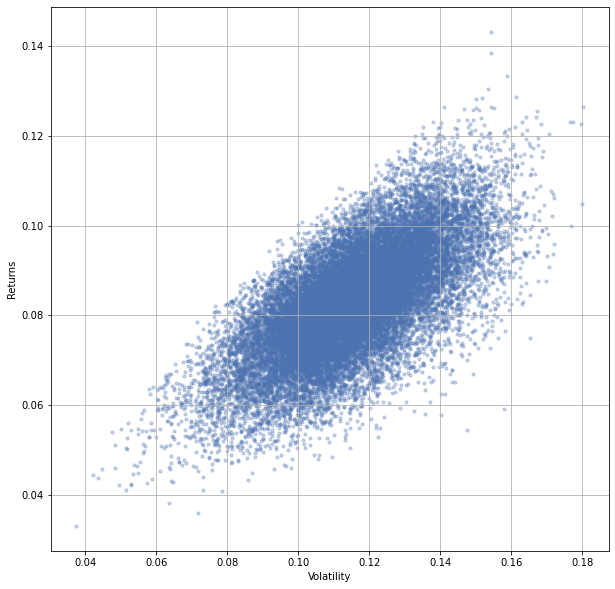

In [94]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

First let's find the portfolio with the minimum volatility for the investor with the smallest risk appetite. 

Returns       0.033117
Volatility    0.037345
AGG           0.356821
EEM           0.055220
EFA           0.108900
IJR           0.008491
JNK           0.006171
SHY           0.457689
SPY           0.006707
Name: 21017, dtype: float64


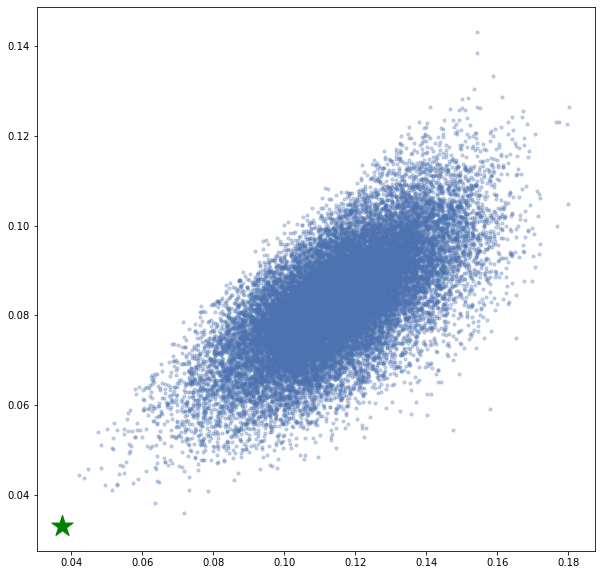

In [95]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]                            
print(min_vol_port)

plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='g', marker='*', s=500)

Next let's find the best sharpe ratio portfolio. For a risk free rate we'll use the current 10 year treasury bond (1.2% as of 8/8/2021).

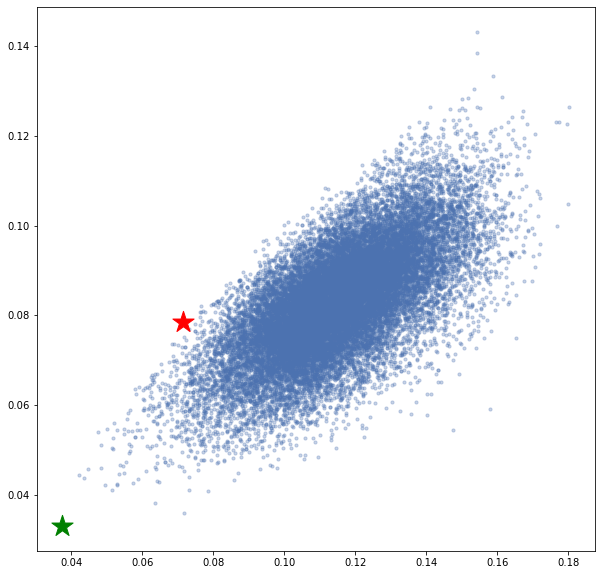

In [96]:
rf = 0.012
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='g', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='r', marker='*', s=500)

Finally, let's get the portfolio with the highest return regardless of risk.

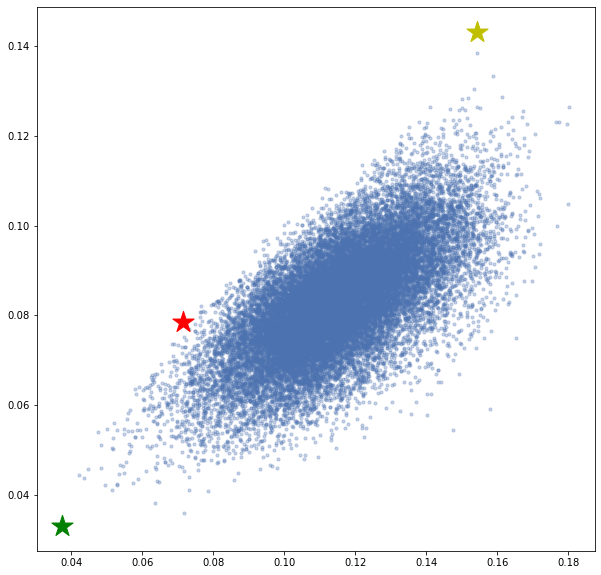

In [97]:
optimal_return_port = portfolios.iloc[(portfolios['Returns']).idxmax()]
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='g', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_return_port[1], optimal_return_port[0], color='y', marker='*', s=500)

Now that we have our three portfolio's, we need clean them then put them into a csv that will be able to be ingested and loaded into our database. We also need to add today's date (date of recommendation).

In [98]:
print(optimal_return_port)

Returns       0.143122
Volatility    0.154243
AGG           0.003333
EEM           0.006092
EFA           0.016765
IJR           0.119697
JNK           0.071228
SHY           0.043158
SPY           0.739727
Name: 4041, dtype: float64


In [132]:
min_vol_port.name = "Conservative"
optimal_risky_port.name = "Balanced"
optimal_return_port.name = "Aggressive"
port_recommend = pd.concat([min_vol_port,optimal_risky_port,optimal_return_port], axis=1).reset_index()
port_recommend = port_recommend.drop(index=[0,1]).reset_index()
port_recommend = port_recommend.drop(columns=['level_0'])
port_recommend = port_recommend.rename(columns={"index": "ticker"})
print(port_recommend)

  ticker  Conservative  Balanced  Aggressive
0    AGG      0.356821  0.265510    0.003333
1    EEM      0.055220  0.006384    0.006092
2    EFA      0.108900  0.023016    0.016765
3    IJR      0.008491  0.004378    0.119697
4    JNK      0.006171  0.008240    0.071228
5    SHY      0.457689  0.299377    0.043158
6    SPY      0.006707  0.393095    0.739727


In [133]:
port_recommend = port_recommend.melt(id_vars=["ticker"], var_name="risk_tolerance", 
        value_name="weight")
today = pd.to_datetime('today').normalize()
port_recommend['recommendation_datetime'] = today
port_recommend['recommendation_date'] = port_recommend['recommendation_datetime'].dt.date
port_recommend = port_recommend.drop(columns=['recommendation_datetime'])
port_recommend = port_recommend[['recommendation_date','risk_tolerance','ticker','weight']]
print(port_recommend)

   recommendation_date risk_tolerance ticker    weight
0           2021-08-09   Conservative    AGG  0.356821
1           2021-08-09   Conservative    EEM  0.055220
2           2021-08-09   Conservative    EFA  0.108900
3           2021-08-09   Conservative    IJR  0.008491
4           2021-08-09   Conservative    JNK  0.006171
5           2021-08-09   Conservative    SHY  0.457689
6           2021-08-09   Conservative    SPY  0.006707
7           2021-08-09       Balanced    AGG  0.265510
8           2021-08-09       Balanced    EEM  0.006384
9           2021-08-09       Balanced    EFA  0.023016
10          2021-08-09       Balanced    IJR  0.004378
11          2021-08-09       Balanced    JNK  0.008240
12          2021-08-09       Balanced    SHY  0.299377
13          2021-08-09       Balanced    SPY  0.393095
14          2021-08-09     Aggressive    AGG  0.003333
15          2021-08-09     Aggressive    EEM  0.006092
16          2021-08-09     Aggressive    EFA  0.016765
17        

In [134]:
port_recommend.to_csv("DataSets/output.csv",index=False)